In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [26]:
import matplotlib.pyplot as plt
import glob
import numpy as np
import stephane.display.graphes as graphes
#import stephane.elasticity.processing as proc
import fluids2d.backlight as bl
import pims
import fluids2d.piv as piv
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
import stephane.cine.cine as cine
import stephane.tools.Smath as Smath
import scipy.interpolate as interp
import sys
from functools import partial
from multiprocessing import Process,Pool
#import lea.h5py_convert as h5pylea

In [4]:

if sys.platform=='win32':
    base = 'F:'
if sys.platform=='linux':
    base = '/media/stephane/DATA'
if sys.platform=='darwin':
    base = '/Volumes'

date = '20181106'
folder = base+'/Experimental_data/Turbulence3d/'+date+'/'
ext = '.cine'
l=glob.glob(folder+'*'+ext)
for i,name in enumerate(l):
    print(str(i)+' : '+os.path.basename(name))

s = input()
try:
    i = int(s)
except:
    print("cannot be converted to an integer")

cinefile = l[i]

0 : PIV3d_nikon50mm_64pumps_random16_fps40k_Pump30Hz_f1kHz_A1600mV_line5.cine
1 : PIV3d_nikon50mm_64pumps_random16_fps40k_Pump30Hz_f1kHz_A1600mV_line5_z450mm.cine
2 : PIV3d_nikon50mm_64pumps_random16_fps40k_Pump30Hz_f800Hz_A1600mV_line5_z400mm.cine
3 : PIV3d_nikon50mm_64pumps_random16_fps40k_Pump30Hz_f800Hz_A1600mV_line5_z400mm_EXPT2.cine
3


In [41]:
cinefile

'/media/stephane/DATA/Experimental_data/Turbulence3d/20181106/PIV3d_nikon50mm_64pumps_random16_fps40k_Pump30Hz_f800Hz_A1600mV_line5_z400mm_EXPT2.cine'

127437


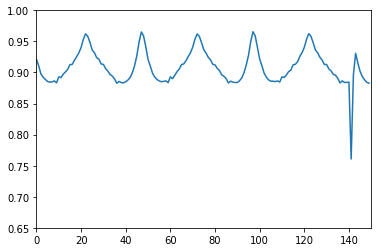

In [6]:
c = pims.open(cinefile)

N=len(c)
C = []

for i in range(N):
    if np.mod(i,10000)<150:
        mean1 = np.mean(c.get_frame(i),axis=(0,1))
        mean2 = np.mean(c.get_frame(i+1),axis=(0,1))
        std1 = np.std(c.get_frame(i),axis=(0,1))
        std2 = np.std(c.get_frame(i+1),axis=(0,1))

        C.append(np.mean((c.get_frame(i)-mean1)*(c.get_frame(i+1)-mean2),axis=(0,1))/(std1*std2))
        if np.mod(i,150)==149:
            plt.plot(C)
            plt.axis([0,150,0.65,1])
            C = []

In [91]:
cinefile

'/media/stephane/DATA/Experimental_data/Turbulence3d/20181106/20181106_5_PIV3d_nikon50mm_64pumps_random16_fps40k_Pump30Hz_f800Hz_A1600mV_line5_z400mm_EXPT2.hdf5'

In [303]:
c=cine.Cine(cinefile)
N = len(c)
timages =   np.asarray([c.get_time(i) for i in range(N)])
#plt.plot(timages)
#plt.plot(np.diff(timages))

tnew= timages[:-1]
jumps = np.logical_and(np.diff(timages)>1.,np.diff(timages)<5)
indices = np.where(jumps)[0]
print(indices)

waittime = np.diff(tnew[indices])
print(waittime)
#plt.figure()
#plt.hist(waittime)
print(np.max(waittime)-np.min(waittime))

instant = []
for i,ind in enumerate(indices[1:-1]):
    start = indices[i]+1
    end = indices[i+1]-1
#    plt.plot(np.diff(timages[start:end]))
    instant.append((start,end))
#plt.axis([0,10,0,4])
print(instant)

[   141    285    429    573    717    861   1005   1150   1295   1439
   1583   1727   1871   2015   2159   2303   2447   2591   2735   2879
   3023   3168   3313   3457   3601   3745   3889   4033   4177   4321
   4465   4609   4753   4897   5041   5185   5330   5475   5619   5763
   5907   6051   6195   6339   6483   6627   6771   6915   7059   7203
   7347   7492   7637   7781   7925   8069   8213   8357   8501   8645
   8789   8933   9077   9221   9365   9510   9655   9800   9944  10088
  10232  10376  10520  10664  10808  10952  11096  11240  11384  11528
  11673  11818  11962  12106  12250  12394  12538  12682  12826  12970
  13114  13258  13402  13546  13691  13836  13981  14125  14269  14413
  14557  14701  14845  14989  15133  15277  15421  15565  15709  15854
  15999  16143  16287  16431  16575  16719  16863  17007  17151  17295
  17439  17583  17727  17872  18017  18162  18306  18450  18594  18738
  18882  19026  19170  19314  19458  19602  19746  19890  20035  20180
  2032

In [64]:
a=range(100)
a[slice(start,end,sign(end-start))]

range(0, 20, -1)

In [304]:
def find_positionlaser(c,instant,a=5,Nz=25):

    instantV = []
    tV = []

    for (start,end) in instant:
        C = []
        print(start)
        for i in range(start,end):
            mean1 = np.mean(c.get_frame(i),axis=(0,1))
            mean2 = np.mean(c.get_frame(i+1),axis=(0,1))
            std1 = np.std(c.get_frame(i),axis=(0,1))
            std2 = np.std(c.get_frame(i+1),axis=(0,1))

            C.append(np.mean((c.get_frame(i)-mean1)*(c.get_frame(i+1)-mean2),axis=(0,1))/(std1*std2))
    
        maximum=[]
        minimum=[]
        for i in range(a,len(C)-a):
            window = slice(i-a,i+a+1)
            if np.argmax(C[window])==a+1:
                maximum.append(i+1)
                plt.plot(i+1-maximum[0],C[i+1],'rx')
                if len(maximum)>1 and len(minimum)>0:
                    # get which way we are scanning
                    if (minimum[-1]-maximum[-2])<=Nz/2:
                        startV = maximum[-2]+start
                        endV = maximum[-1]+start
                    else:
                        startV = maximum[-1]+start
                        endV = maximum[-2]+start
                    instantV.append((startV,endV))
                    tV.append(c.get_time((startV+endV)//2))

                        
            if np.argmin(C[window])==a+1:
                if len(maximum)>0:
                    minimum.append(i+1)
                    
                    if (minimum[-1]-maximum[-1])<=Nz/2:
                        plt.plot(i+1-maximum[0],C[i+1],'bo')
                    else:
                        plt.plot(i+1-maximum[0],C[i+1],'k*')
                        #do a mirror symetry
                        
                
        plt.plot(C[maximum[0]:maximum[-1]])   
        plt.axis([0,150,0.65,1])
    return (instantV,tV)

142
286
430
574
718
862
1006
1151
1296
1440
1584
1728
1872
2016
2160
2304
2448
2592
2736
2880
3024
3169
3314
3458
3602
3746
3890
4034
4178
4322
4466
4610
4754
4898
5042
5186
5331
5476
5620
5764
5908
6052
6196
6340
6484
6628
6772
6916
7060
7204
7348
7493
7638
7782
7926
8070
8214
8358
8502
8646
8790
8934
9078
9222
9366
9511
9656
9801
9945
10089
10233
10377
10521
10665
10809
10953
11097
11241
11385
11529
11674
11819
11963
12107
12251
12395
12539
12683
12827
12971
13115
13259
13403
13547
13692
13837
13982
14126
14270
14414
14558
14702
14846
14990
15134
15278
15422
15566
15710
15855
16000
16144
16288
16432
16576
16720
16864
17008
17152
17296
17440
17584
17728
17873
18018
18163
18307
18451
18595
18739
18883
19027
19171
19315
19459
19603
19747
19891
20036
20181
20325
20469
20613
20757
20901
21045
21189
21333
21477
21621
21765
21909
22054
22199
22344
22488
22632
22776
22920
23064
23208
23352
23496
23640
23784
23928
24072
24217
24362
24506
24650
24794
24938
25082
25226
25370
25514
25658
25802
2

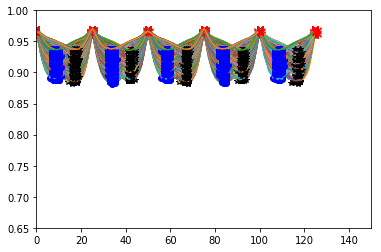

In [305]:
(instantV,tV) = find_positionlaser(c,instant,a=5,Nz=25)

In [141]:
len(instantV)

437

In [314]:
N

127437

In [309]:
dataname = cinefile.rsplit(".",1)[0]
save_folder = os.path.dirname(cinefile)+ '/Stat/'

dx =  0.277E-03#7.3469357156E-05
dt_orig = 1./40000

crop_lims=None
pre_constructed_masker = None
t0 = 0
a_frames = np.arange(t0,10000+t0,1)
frame_diff = 40

window_size = 32
overlap = 16

processing = piv.PIVDataProcessing('',cinefile,name_for_save=dataname,dx=dx,dt_orig=dt_orig,frame_diff=frame_diff,crop_lims=crop_lims,maskers=None,window_size=window_size,overlap=overlap,search_area_size=32)
processing.associate_flowfield()
print(processing)
ff = processing.data.ff
print(ff.shape)

dx : 
0.000277
dt_ab: 
0.001
(101560, 23, 63, 2)


In [311]:
print(ff.shape)
print(ff.shape[0]//50)

ff = ff[:2031*50,...]
print(ff.shape)

(101560, 23, 63, 2)
2031
(101550, 23, 63, 2)


In [313]:
print(ff.shape)

(101550, 23, 63, 2)


In [315]:
N = ff.shape[0]

c=0
for i,(start,end) in enumerate(instantV):
    if start<N and end<N and np.abs(start-end)==25:
        c=c+1
    if c==1:
        data0 = ff[slice(start,end,np.sign(end-start)),...] 
data = np.zeros((c,)+data0.shape)
print(data.shape)
c=0
for i,(start,end) in enumerate(instantV):
    if start<N and end<N and np.abs(start-end)==25:
        data[c,...] = ff[slice(start,end,np.sign(end-start)),...]
        c=c+1
data = np.asarray(data)
print(data.shape)

(2903, 25, 23, 63, 2)
(2903, 25, 23, 63, 2)


In [316]:
def nancount(data):
    print(data.shape)
    Nnan = np.sum(np.ndarray.flatten(np.isnan(data)))
    N = np.prod(data.shape)
    print('Ratio nan :' +str(Nnan/N))
    print('nan number :'+str(Nnan))

In [317]:
nancount(data)

(2903, 25, 23, 63, 2)
Ratio nan :0.26465907688840484
nan number :55663719


In [147]:
instantV = np.asarray(instantV)
tV = np.asarray(tV)

In [321]:
ff=data
print(ff.shape)

(2903, 25, 23, 63, 2)


/home/stephane/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/stephane/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


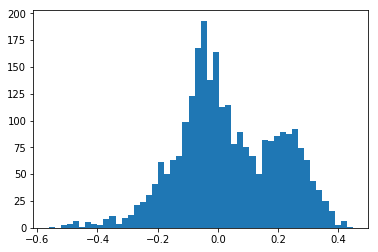

In [319]:
a = plt.hist(np.ndarray.flatten(ff[51,...]),50)

In [322]:
S = np.nanstd(ff[...,0],axis=(1,2,3))
ff = ff[S<0.25,...]
print(ff.shape)

(1366, 25, 23, 63, 2)


In [323]:
nancount(ff)

(1366, 25, 23, 63, 2)
Ratio nan :0.07554112645970816
nan number :7476056


In [324]:
ff = ff[...,1:-1,1:-1,:]
nancount(ff)

(1366, 25, 21, 61, 2)
Ratio nan :0.001864118328127161
nan number :163096


In [159]:
nancount(ff)

(158, 25, 21, 61, 2)
Ratio nan :0.0008664117234360024
nan number :8768


In [325]:
ff = ff[:,2:-2,...]
nancount(ff)

(1366, 21, 21, 61, 2)
Ratio nan :0.0006022298669765933
nan number :44260


In [175]:
indices[0][1]
indices[1][0]

4

In [184]:
tuple()+(1,)

(1,)

In [326]:
#remove nans
indices = np.where(np.isnan(ff))
N = len(indices[0])
for i in range(N):
    ff[indices[0][i],indices[1][i],indices[2][i],indices[3][i],indices[4][i]]=0

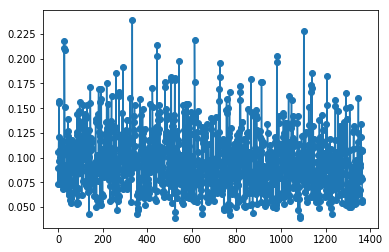

In [328]:
S = np.nanstd(ff[...,0],axis=(1,2,3))
plt.plot(S,'o-')
#plt.axis([0,150,0,1])

In [329]:
nancount(ff)

(1366, 21, 21, 61, 2)
Ratio nan :0.0
nan number :0


In [330]:
#compute mean_flow
mean_flow = np.nanmean(ff,axis=0)
mean_flow_speed = np.linalg.norm(mean_flow,axis=2)
mean_speed = np.nanmean( np.sqrt(ff[...,0]**2 + ff[...,1]**2 ), axis=0)
fluc = ff - mean_flow 
u_rms = np.sqrt(np.nanmean(fluc[...,0]**2+fluc[...,1]**2 ,axis=0) )

In [331]:
#generate axis
(Nz,Nx,Ny,Nc) = mean_flow.shape
#mean_flow = np.transpose(mean_flow,(1,2,0,3))

overlap = 16
fx = 0.277

dz = 42/25
x = np.arange(-(Nx-1)/2,(Nx-1)/2+1)*fx*overlap
y = np.arange(-(Ny-1)/2,(Ny-1)/2+1)*fx*overlap
z = np.arange(-Nz/2,Nz/2)*dz-2

#invariance by rotation in the plane (x,z)

[X,Z,Y] = np.meshgrid(x,z,y)
print(X.shape)
print(max(x))
print(max(y))
print(max(z))

(21, 21, 61)
44.32000000000001
132.96
13.959999999999999


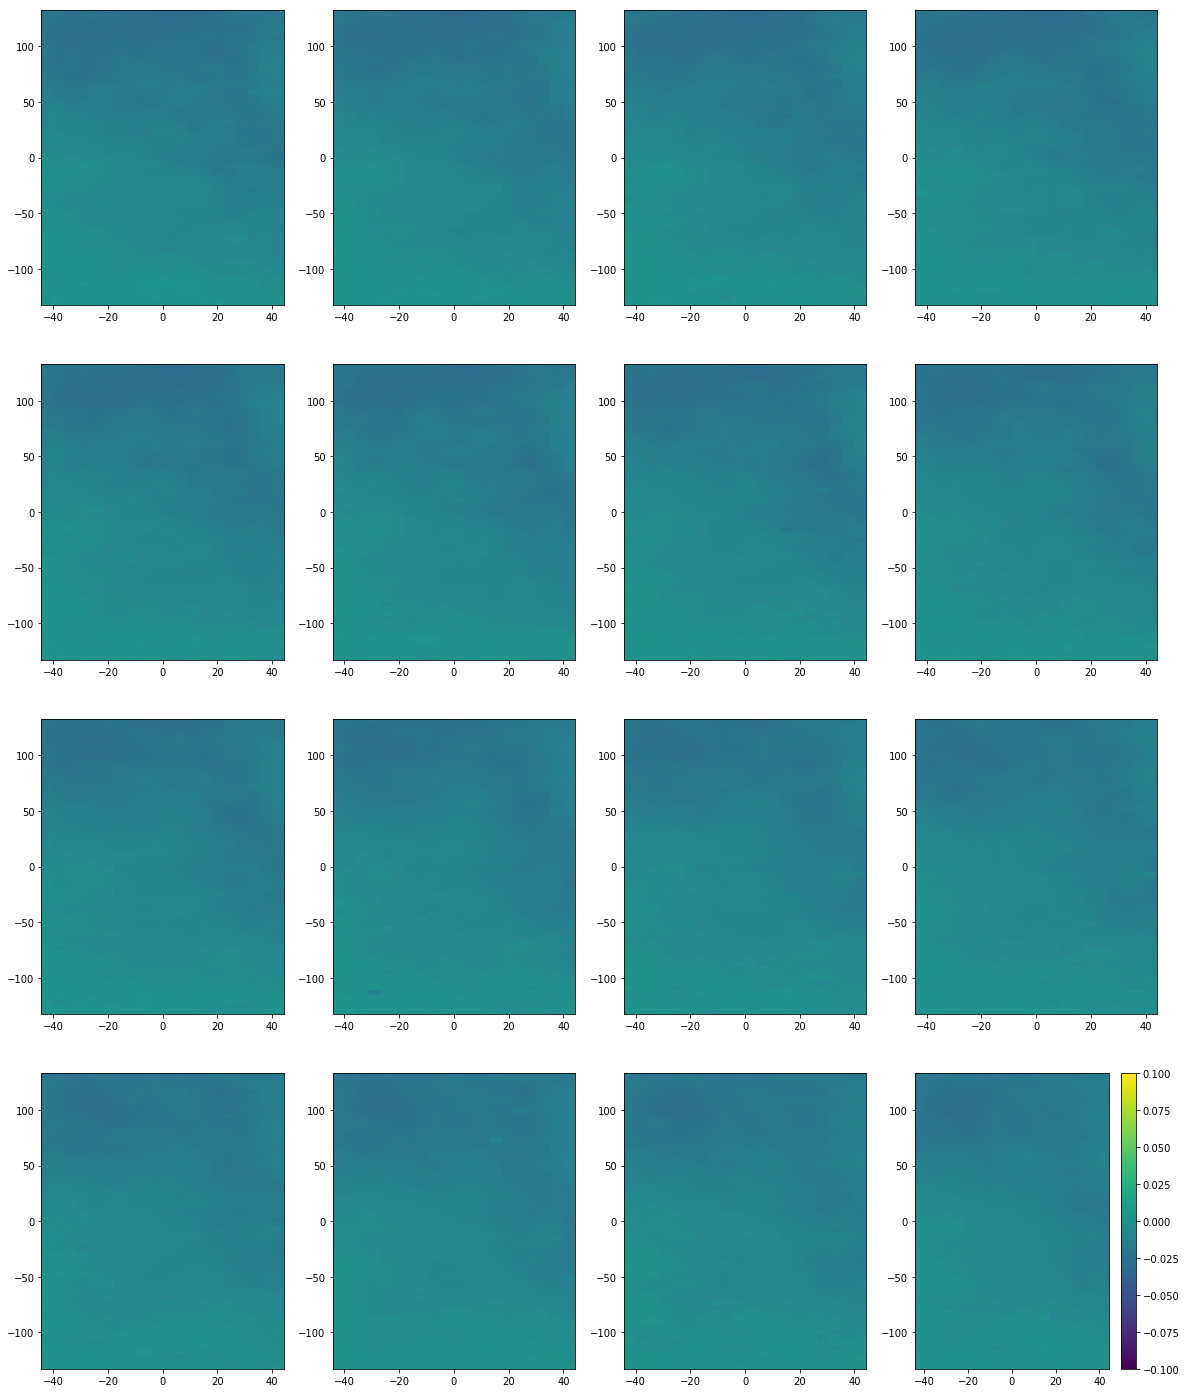

In [332]:
fig,axs=plt.subplots(4,4,figsize=(20,25))

for i in range(4):
    for j in range(4):
        plt.subplot(4,4,i*4+j+1)
        plt.pcolormesh(X[0,...],Y[0,...],mean_flow[i*4+j,...,0],vmin=-0.1,vmax=0.1)
#    plt.colorbar()
plt.colorbar()

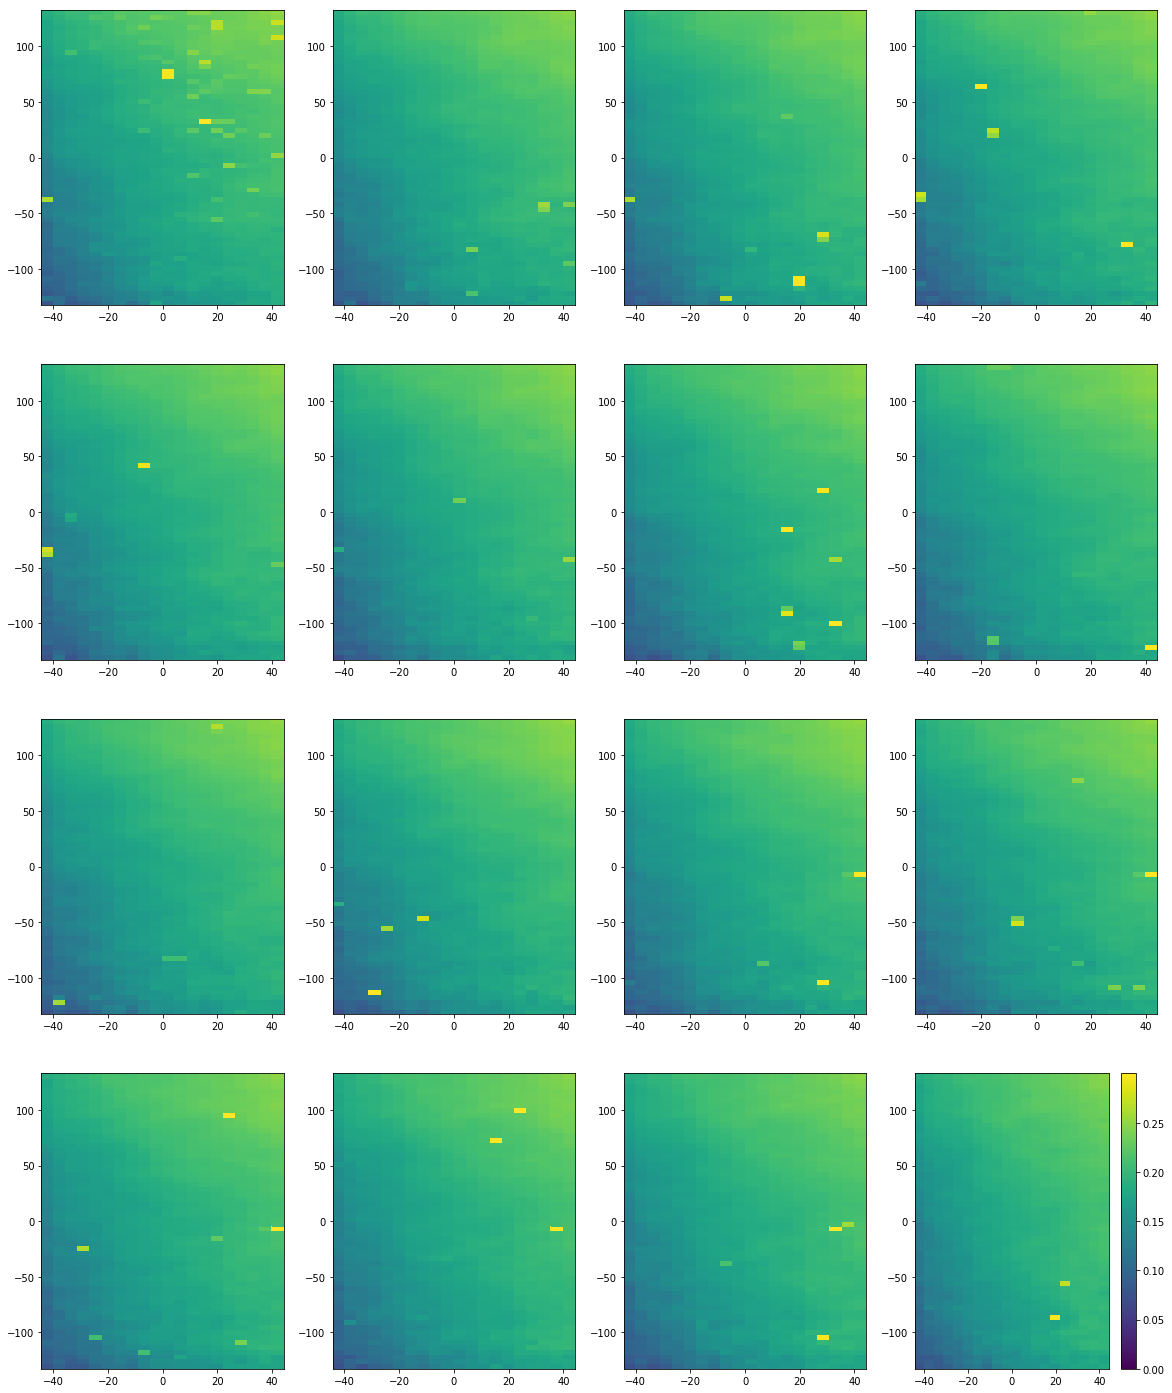

In [333]:
fig,axs=plt.subplots(4,4,figsize=(20,25))

for i in range(4):
    for j in range(4):
        plt.subplot(4,4,i*4+j+1)
        plt.pcolormesh(X[0,...],Y[0,...],u_rms[i*4+j,...],vmin=0,vmax=0.3)
#    plt.colorbar()
plt.colorbar()

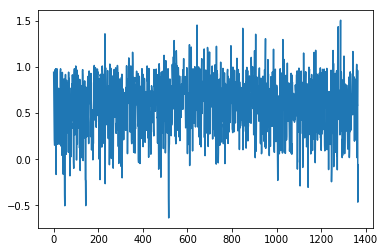

In [360]:
i=5
plt.plot(np.nanmean(fluc[:,i,...,0]*fluc[:,i+15,...,0],axis=(1,2))/np.nanmean(fluc[:,i,...,0]**2,axis=(1,2)))

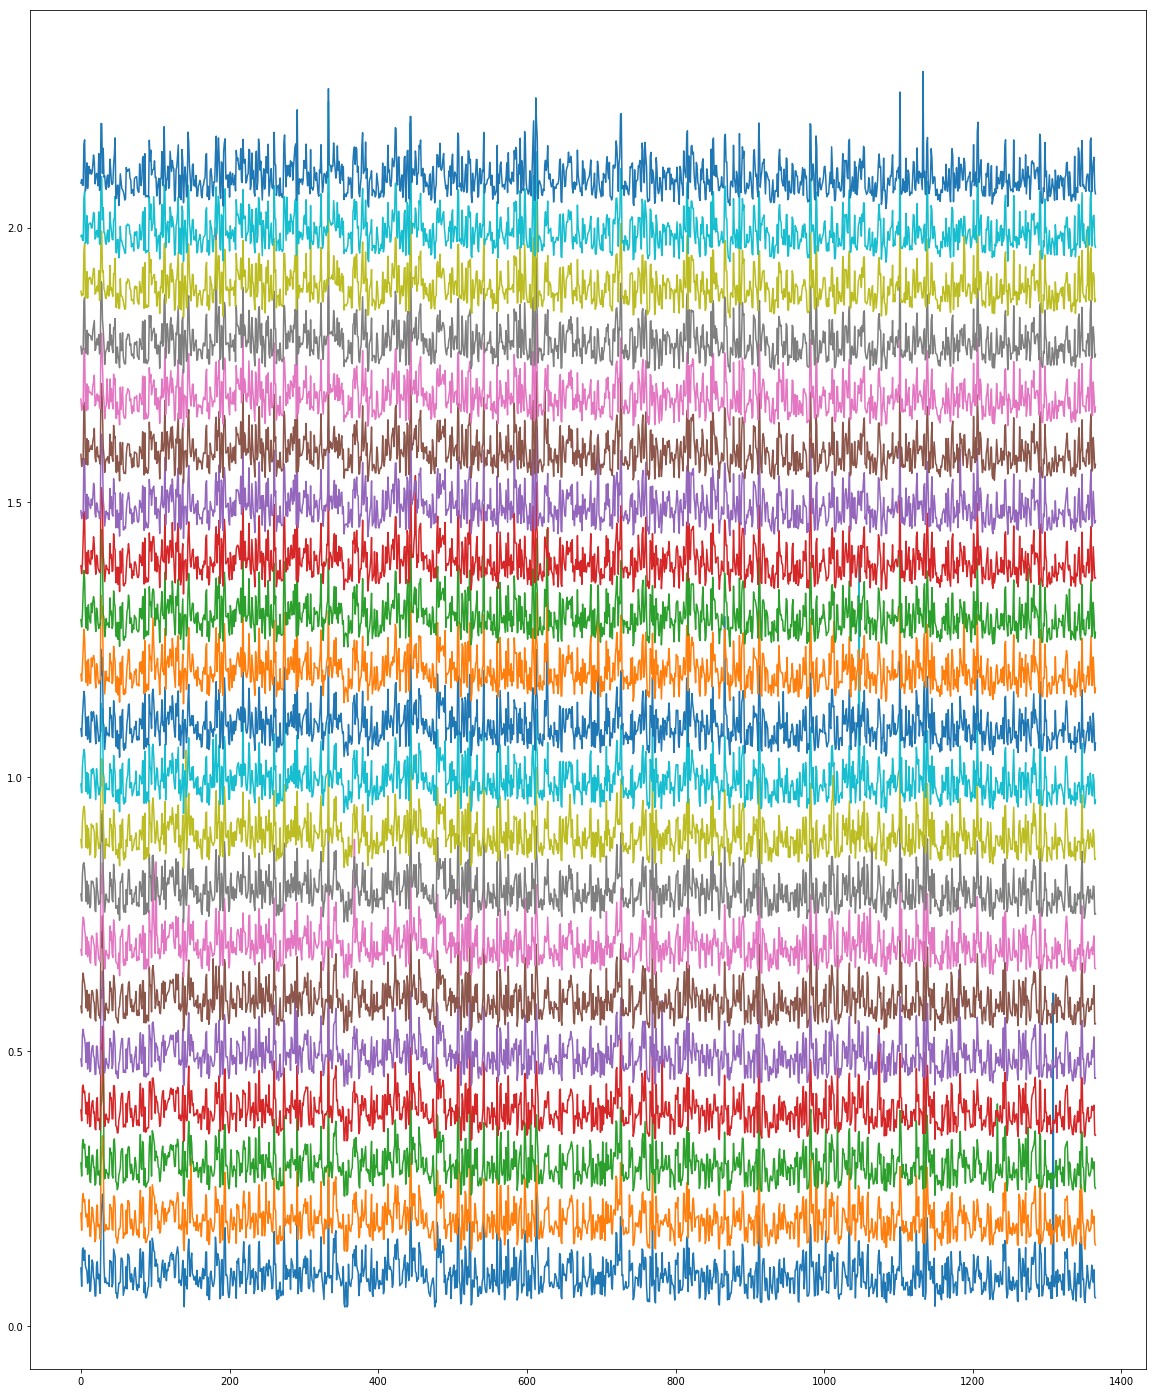

In [352]:
fig,axs=plt.subplots(1,1,figsize=(20,25))
for i in range(21):
    plt.plot(np.nanstd(fluc[:,i,...,0],axis=(1,2))+i*0.1)

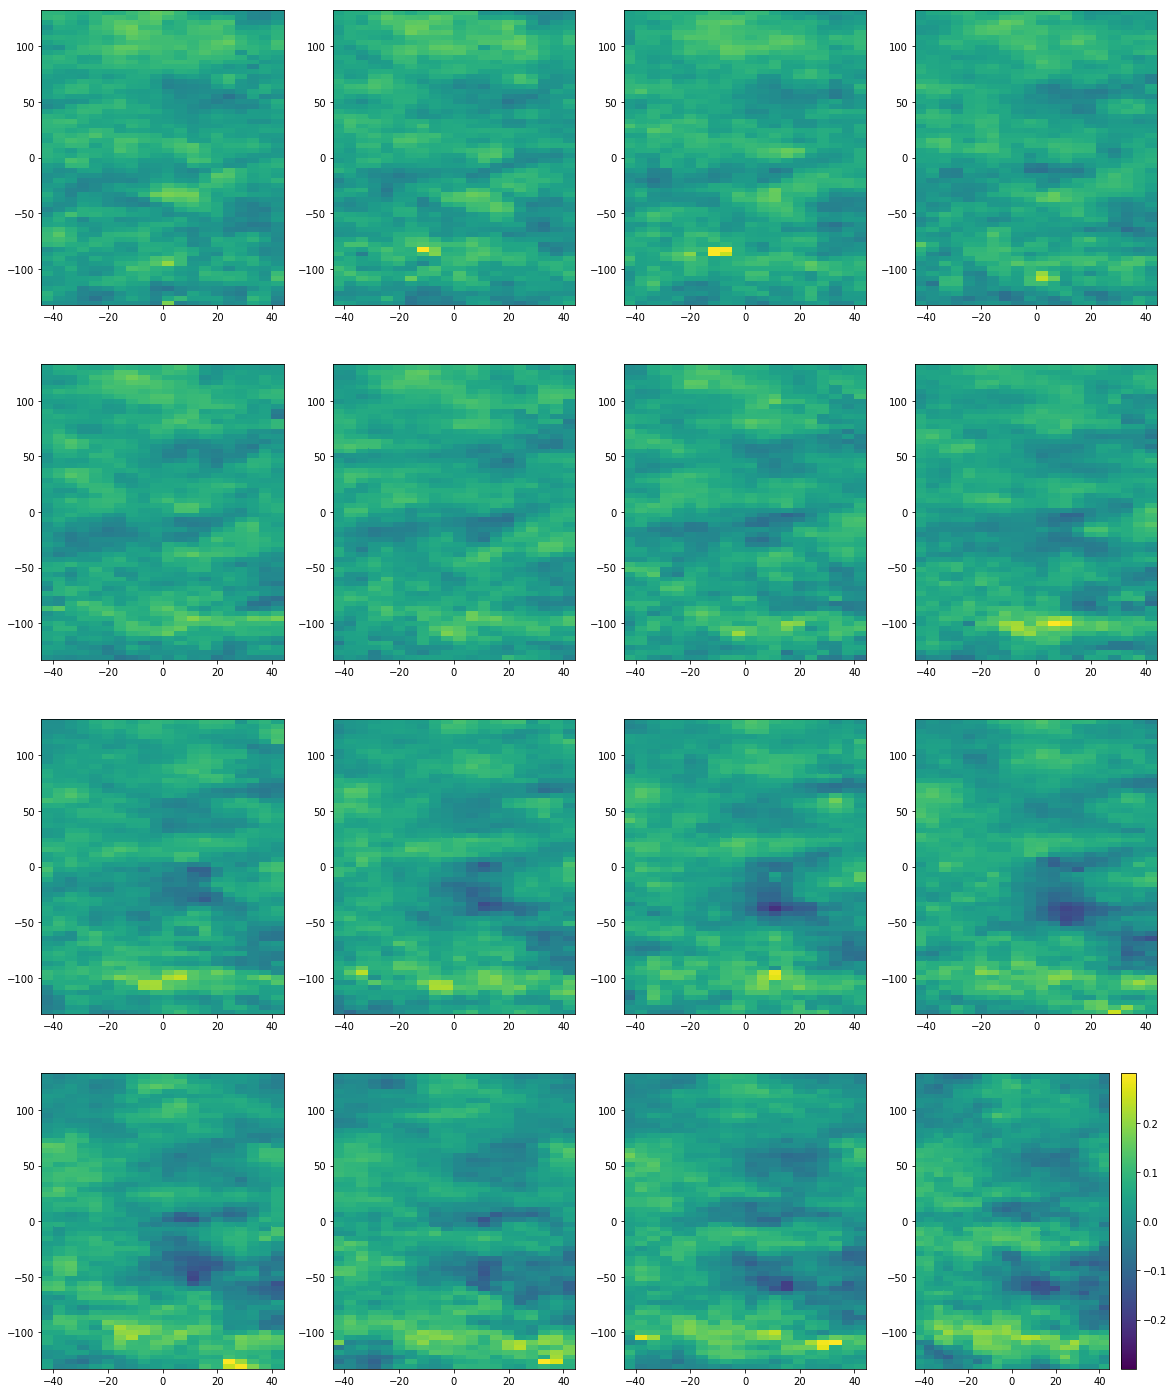

In [362]:
fig,axs=plt.subplots(4,4,figsize=(20,25))

for i in range(4):
    for j in range(4):
        plt.subplot(4,4,i*4+j+1)
        plt.pcolormesh(X[0,...],Y[0,...],fluc[600,i*4+j,...,1],vmin=-0.3,vmax=0.3)
#    plt.colorbar()
plt.colorbar()

In [385]:
fluc.shape

(1366, 21, 21, 61, 2)

In [397]:
np.nanmean(np.zeros((5,5)))

0.0

In [408]:
#creation d'une matrice 2d de corrélation
N=fluc.shape[0]
C = np.zeros((N,N))
for i in range(N):
    if np.mod(i,100)==0:
        print(i)
    for j in range(N):
        facteur = np.nanstd(fluc[i,10,...,0],axis=(0,1))*np.nanstd(fluc[j,10,...,0],axis=(0,1))
        C[i,j] = np.nanmean((fluc[i,10,...,0]-np.nanmean(fluc[i,10,...,0]))*(fluc[j,10,...,0]-np.nanmean(fluc[j,10,...,0])),axis=(0,1))/facteur                          

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300


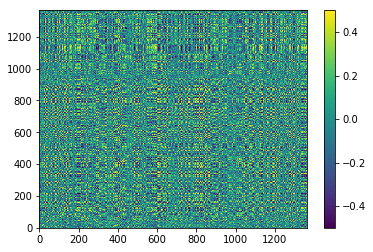

In [431]:
times = range(N)
#indices = np.argsort(C)

plt.pcolormesh(times,times,C,vmin=-0.5,vmax=0.5)
plt.colorbar()

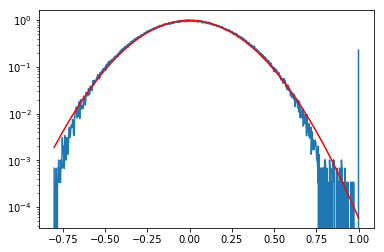

In [430]:
[n,xbin] = np.histogram(np.ndarray.flatten(C),1000)
x = (xbin[:-1]+xbin[1:])/2
plt.semilogy(x,n/max(n))
x0 = 0.32
alpha = 2
plt.semilogy(x,np.exp(-(x/x0)**alpha),'r')
#distribution gaussienne des corrélations entre mode

In [439]:
np.mean(C) #la corrélation moyenne entre deux réalisations est identiquement nulle. -> normal, on a retranché l'écoulement moyenné en temps
#en revanche, grosse variation de C autour de 0. Deux réalisations du bruit sont en moyenne de corrélation non nulle

#-> idem pour deux points situés loin l'un de lautre à un même instant ?
#oui, mais dans ce cas la corrélation devrait être tantôt positive, tantôt négative


0.00015949107268021595

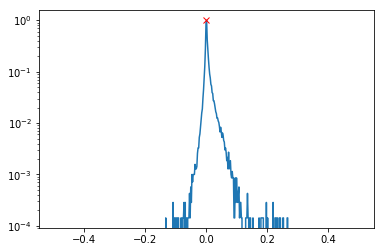

In [559]:
i0 = 5
j0 = 10
mean = np.nanmean(flucv[:,:,i0,j0,0])
Cmap = flucv[:,:,i0,j0,0]*flucv[:,:,i0,j0+20,0]

[n,xbin] = np.histogram(np.ndarray.flatten(Cmap),500,[-0.5,0.5])
x = (xbin[:-1]+xbin[1:])/2
plt.semilogy(x,n/max(n))
x0 = 0.32
alpha = 2
plt.plot(0,1,'rx')



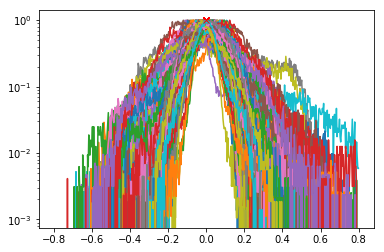

In [570]:
i0 = 5
j0 = 10
mean = np.nanmean(flucv[:,:,i0,j0,0])

stat = np.zeros()
for i in range(200):
    Cmap = flucv[i,...,0]
    mean = np.nanmean(flucv[i,...,0])

    [n,xbin] = np.histogram(np.ndarray.flatten(Cmap-mean),500,[-0.8,0.8])
    x = (xbin[:-1]+xbin[1:])/2
    plt.semilogy(x,n/max(n))
    plt.plot(0,1,'rx')



4
(1366, 21, 4)
(1366, 21)
0.9160250080903946


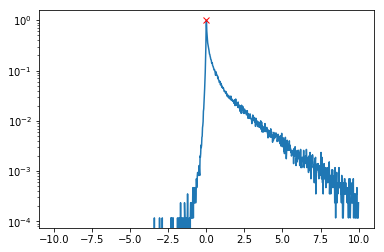

In [528]:
flucv = fluc

Nt = fluc.shape[0]
(Nz,Nx,Ny) = X.shape
(k0,i0,j0) = tuple(np.asarray(X.shape)//2)

x0 = X[k0,i0,j0]
y0 = Y[k0,i0,j0]
z0 = Z[k0,i0,j0]


[R,Theta] = Smath.cart2pol(X[k0,...]-x0,Y[k0,...]-y0)
#R = np.sqrt((Xv-x0)**2+(Yv-y0)**2)

d = 5#np.max(R)*0.02
indices = np.logical_and(R>=d,R<d*1.5)

n = np.sum(indices)
print(n)

u0 = flucv[:,:,i0,j0,0]
ud = flucv[:,:,indices,0]

print(ud.shape)

stdu0 = np.std(flucv[:,:,i0,j0,0])
stdud = np.std(flucv[:,:,indices,0])

print(u0.shape)
Cmap = ud*np.transpose(np.tile(u0,(n,1,1)),(1,2,0))/(stdu0*stdud)

[n,xbin] = np.histogram(np.ndarray.flatten(Cmap),1000,[-10,10])
x = (xbin[:-1]+xbin[1:])/2
plt.semilogy(x,n/max(n))
x0 = 0.32
alpha = 2
plt.plot(0,1,'rx')

print(np.nanmean(Cmap))

#distribution des valeurs du produit u(x,t)u(x+d,t)


#plt.semilogy(x,np.exp(-(x/x0)**alpha),'r')
#distribution gaussienne des corrélations entre mode

In [443]:
N = 1366
fluc2 = np.zeros(fluc.shape)
for i in range(N):
    for j in range(2):
        fluc2[i,...,j] = fluc[i,...,j] - np.nanmean(fluc[i,...,j])
print(fluc2.shape)

(1366, 21, 21, 61, 2)


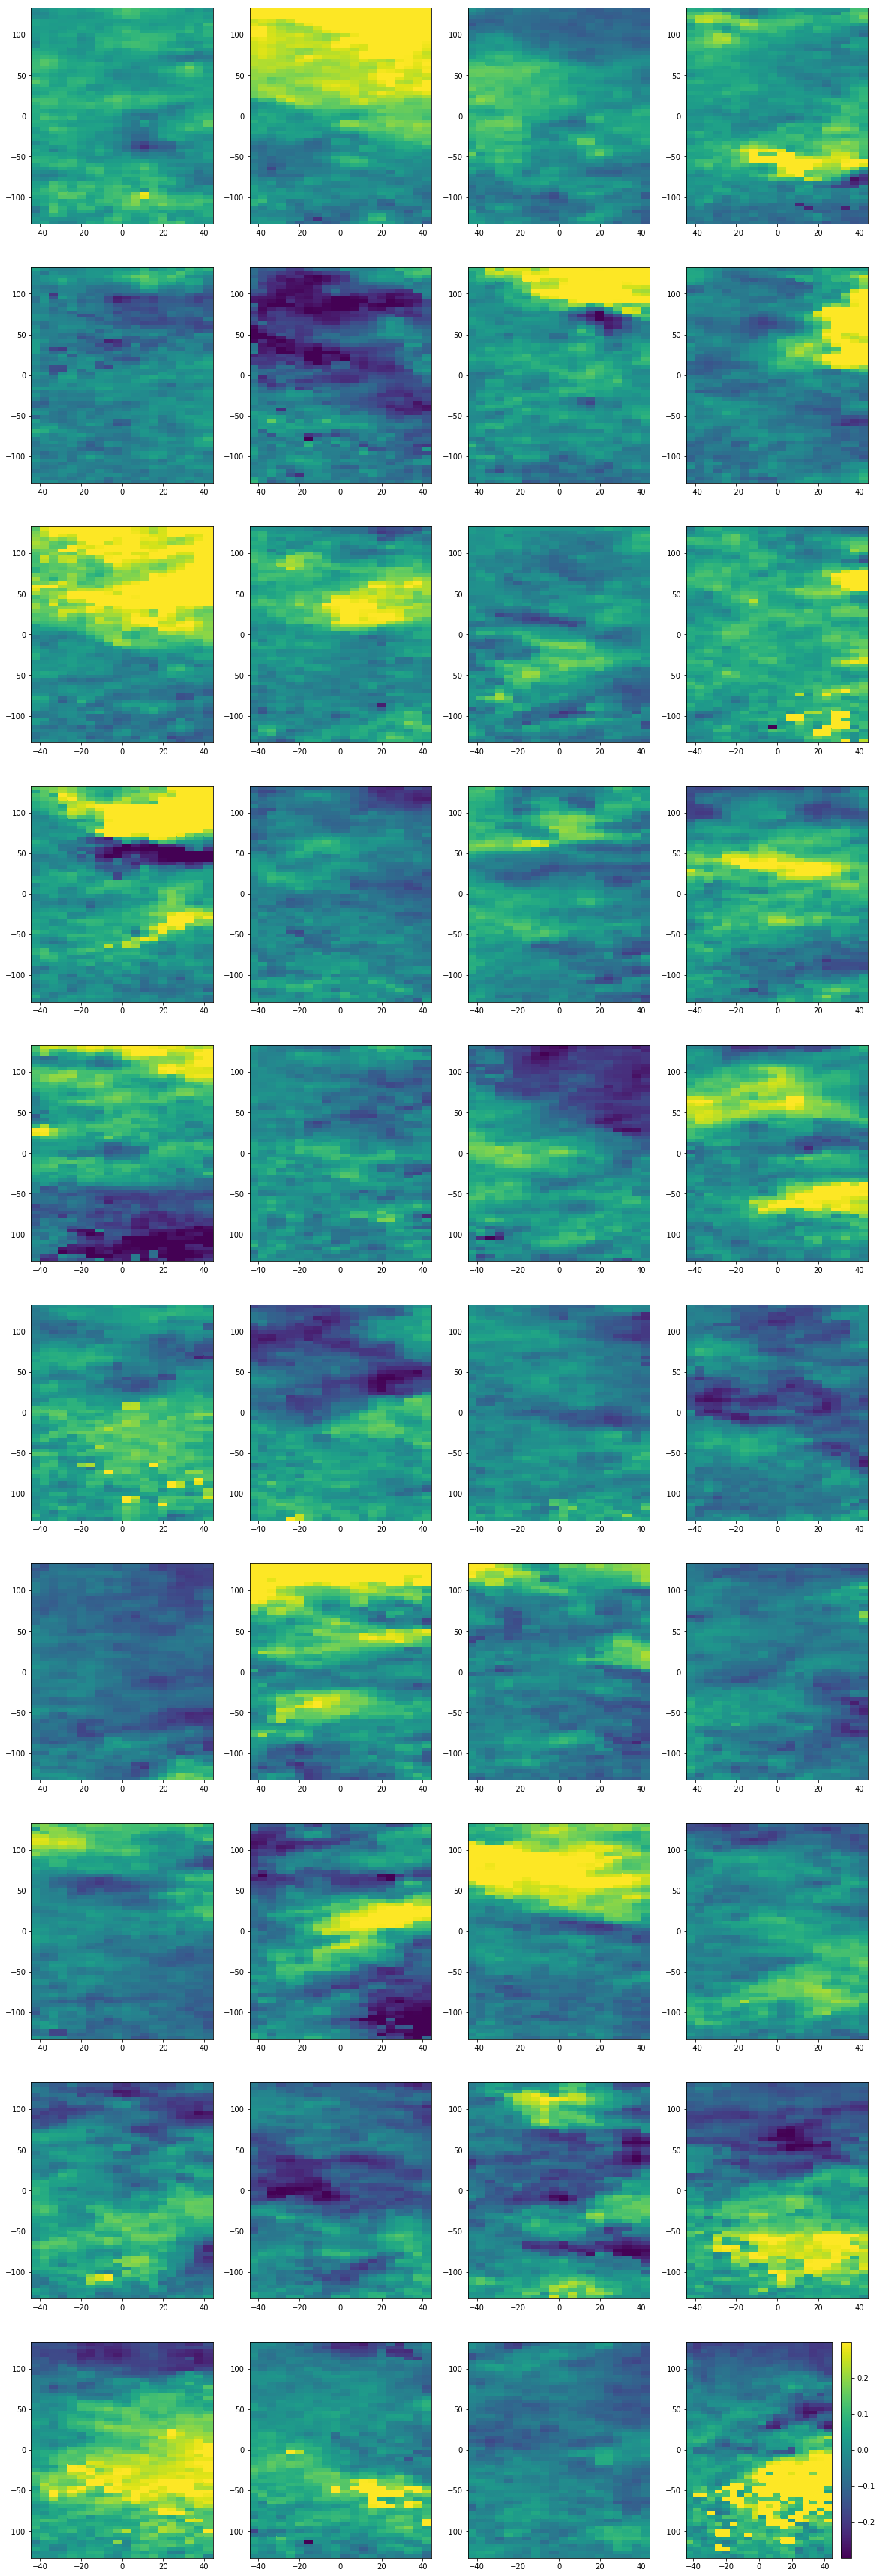

In [367]:
fig,axs=plt.subplots(10,4,figsize=(20,25*2.5))

for i in range(10):
    for j in range(4):
        plt.subplot(10,4,i*4+j+1)
        plt.pcolormesh(X[0,...],Y[0,...],fluc[600+(i*4+j)*10,10,...,1],vmin=-0.3,vmax=0.3)
#    plt.colorbar()
plt.colorbar()

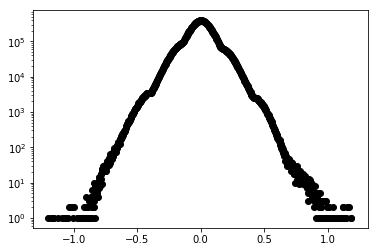

In [384]:
(n,xbin) = np.histogram(np.ndarray.flatten(fluc[...,0]),1000,range=[-1.2,1.2])

plt.semilogy(xbin[:-1],n,'ko')

(1366, 21, 21, 61)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice
/usr/lib/python3/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice


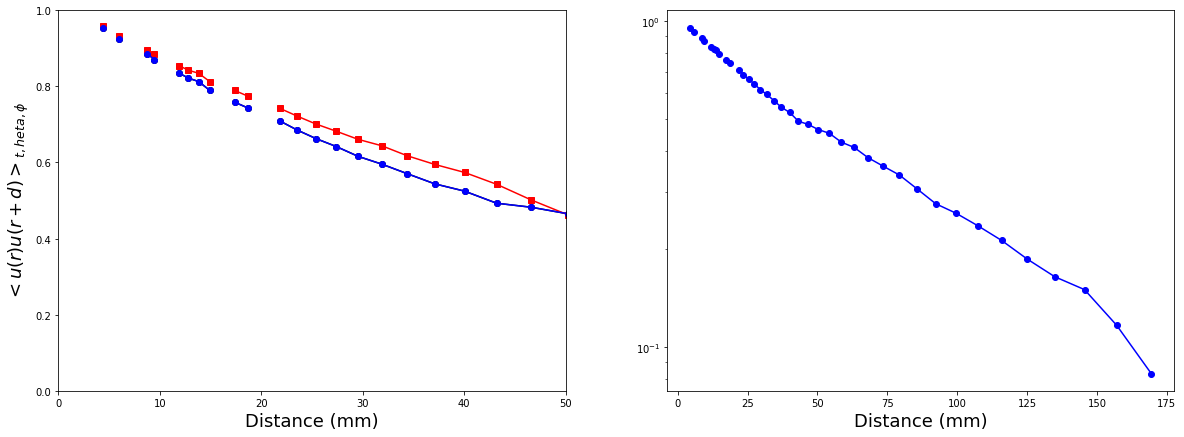

In [458]:
flucv = fluc

Nt = fluc.shape[0]
(Nz,Nx,Ny) = X.shape
(k0,i0,j0) = tuple(np.asarray(X.shape)//2)

j0 = 40
#i0 = 5

x0 = X[k0,i0,j0]
y0 = Y[k0,i0,j0]
z0 = Z[k0,i0,j0]

[R,Theta] = Smath.cart2pol(X-x0,Y-y0)
#R = np.sqrt((Xv-x0)**2+(Yv-y0)**2)

ff2u = np.nanmean(flucv[...,i0,j0,0]**2)
ff2v = np.nanmean(flucv[...,i0,j0,1]**2)

ffu = np.nanstd(flucv[...,0],axis=0)
ffv = np.nanstd(flucv[...,1],axis=0)


Cmapu = flucv[...,0]*np.transpose(np.tile(flucv[...,i0,j0,0],(Nx,Ny,1,1)),(2,3,0,1))
Cmapv = flucv[...,1]*np.transpose(np.tile(flucv[...,i0,j0,1],(Nx,Ny,1,1)),(2,3,0,1))

#Cmapu = Cmapu/np.tile(ffu,(Nt,1,1,1))
#Cmapv = Cmapv/np.tile(ffv,(Nt,1,1,1))


print(Cmapu.shape)
dlist = np.logspace(np.log10(np.min(R[R>0])),np.log10(np.max(R)),50)

Cdu = []
Cdv = []
Cd = []
for i,d in enumerate(dlist[:-1]):
    indices = np.logical_and(R>=dlist[i],R<dlist[i+1])
    #print(np.sum(indices))
    C0u = np.nanmean(Cmapu[...,indices])
    C0v = np.nanmean(Cmapv[...,indices])
    
    #print(C0u/ff2u)
    
    Cd.append((C0u)/(ff2u))
#    C0l = 
#    C0t = 
    Cdu.append(C0u/ff2u)
    Cdv.append(C0v/ff2v)


Cd = np.asarray(Cd)
fig,axs=plt.subplots(1,2,figsize=(20,7))
plt.subplot(1,2,1)
plt.plot(dlist[:-1],Cdu,'ko-')
plt.plot(dlist[:-1],Cdv,'rs-')
plt.plot(dlist[:-1],Cd,'bo-')

plt.axis([0,50,0,1])
fig = graphes.legende('Distance (mm)','$<u(r)u(r+d) >_{t,\theta,\phi}$','')
                  
plt.subplot(1,2,2)
plt.semilogy(dlist[:-1],Cd,'bo-')

#plt.plot(dlist[:-1],Cdu,'ko-')
#plt.plot(dlist[:-1],Cdv,'rs-')
#plt.plot(dlist,np.zeros(len(dlist)),'k--')
#plt.axis([0,300,-0.5,1])
fig = graphes.legende('Distance (mm)','','')

(1366, 21, 21, 61)
0.8931236342959546
nan
nan
nan
0.8438481822281197
nan
nan
nan
0.8012399258759788
nan
0.7846593036736609
nan
0.7459086971823131
0.7370944466989626
0.7243757251838462
0.6991106057286887
nan
0.6704340059703977
0.6615369910055453
nan
0.63012493341975
0.608114578046613
0.583695737385329
0.5695541819318664
0.5426569511939184
0.5113988763864833


/usr/lib/python3/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice
/usr/lib/python3/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice


0.4901050590948021
0.4580438537304269
0.42617141647805146
0.41160846734825707
0.40815369906111876
0.40133947789758867
0.44414455893009996
0.4387698067054623
0.434220701739906
0.4170491018079695
0.4012181781090839
0.3705607915941661
0.35091241811601387
0.33100985318762294
0.31091799289786737
0.2875337783242035
0.2621667597933832
0.24196518417781837
0.23258171531305227
0.21705626212299348
0.19965146347866727
0.1818080926523678
0.15822776770306876


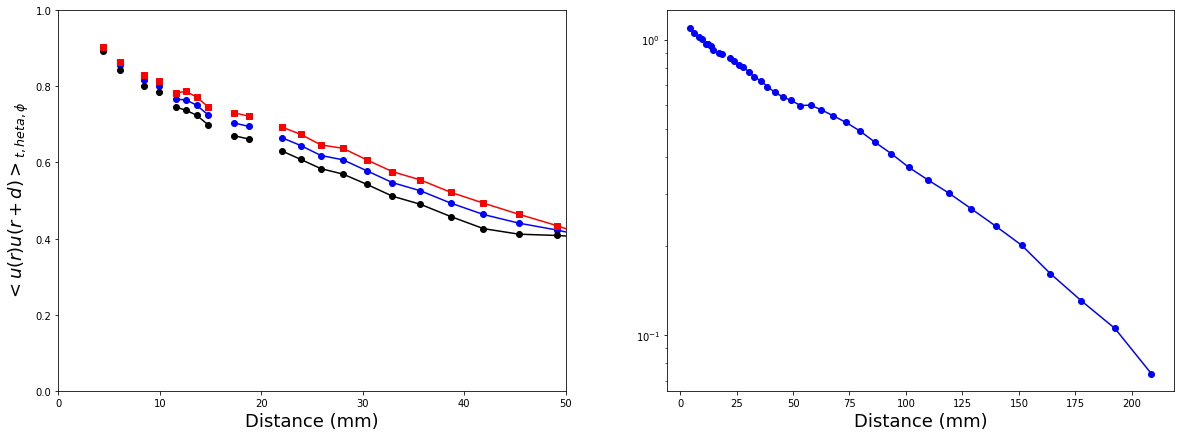

In [448]:
flucv = fluc

Nt = fluc.shape[0]
(Nz,Nx,Ny) = X.shape
(k0,i0,j0) = tuple(np.asarray(X.shape)//2)

j0 = 10
#i0 = 5

x0 = X[k0,i0,j0]
y0 = Y[k0,i0,j0]
z0 = Z[k0,i0,j0]

[R,Theta] = Smath.cart2pol(X-x0,Y-y0)
#R = np.sqrt((Xv-x0)**2+(Yv-y0)**2)

ff2u = np.nanmean(fluc[...,i0,j0,0]**2)
ff2v = np.nanmean(fluc[...,i0,j0,1]**2)

ffu = np.nanstd(fluc[...,0],axis=0)
ffv = np.nanstd(fluc[...,1],axis=0)


Cmapu = fluc[...,0]*np.transpose(np.tile(fluc[...,i0,j0,0],(Nx,Ny,1,1)),(2,3,0,1))
Cmapv = fluc[...,1]*np.transpose(np.tile(fluc[...,i0,j0,1],(Nx,Ny,1,1)),(2,3,0,1))

#Cmapu = Cmapu/np.tile(ffu,(Nt,1,1,1))
#Cmapv = Cmapv/np.tile(ffv,(Nt,1,1,1))


print(Cmapu.shape)
dlist = np.logspace(np.log10(np.min(R[R>0])),np.log10(np.max(R)),50)

Cdu = []
Cdv = []
Cd = []
for i,d in enumerate(dlist[:-1]):
    indices = np.logical_and(R>=dlist[i],R<dlist[i+1])
    #print(np.sum(indices))
    C0u = np.nanmean(Cmapu[...,indices])
    C0v = np.nanmean(Cmapv[...,indices])
    
    print(C0u/ff2u)
    
    Cd.append((C0u+C0v)/(ff2u+ff2v))
#    C0l = 
#    C0t = 
    Cdu.append(C0u/ff2u)
    Cdv.append(C0v/ff2v)

Cd = np.asarray(Cd)
fig,axs=plt.subplots(1,2,figsize=(20,7))
plt.subplot(1,2,1)
plt.plot(dlist[:-1],Cd,'bo-')
plt.plot(dlist[:-1],Cdu,'ko-')
plt.plot(dlist[:-1],Cdv,'rs-')
plt.axis([0,50,0,1])
fig = graphes.legende('Distance (mm)','$<u(r)u(r+d) >_{t,\theta,\phi}$','')
                  
plt.subplot(1,2,2)
plt.semilogy(dlist[:-1],Cd+0.2,'bo-')

#plt.plot(dlist[:-1],Cdu,'ko-')
#plt.plot(dlist[:-1],Cdv,'rs-')
#plt.plot(dlist,np.zeros(len(dlist)),'k--')
#plt.axis([0,300,-0.5,1])
fig = graphes.legende('Distance (mm)','','')

In [133]:
print(fluc.shape)
print(np.sum(np.isnan(np.ndarray.flatten(fluc))))
print(np.prod(np.asarray(fluc.shape)))

(151, 25, 23, 63, 2)
809378
10939950


In [139]:
indices = np.where(np.isnan(fluc[:,:,1:-1,1:-1,:]))
len(indices)

5

In [337]:
Ek = np.abs(np.fft.fftshift(np.fft.fftn(fluc[...,0]**2,axes=(1,2,3)),axes=(1,2,3)))

In [237]:
print(Ek.shape)
print(np.sum(np.isnan(np.ndarray.flatten(Ek))))
print(np.prod(np.asarray(Ek.shape)))

(151, 21, 21, 61)
0
4062051


In [238]:
Ek3d = np.nanmean(Ek,axis=0)
print(Ek3d.shape)

(21, 21, 61)


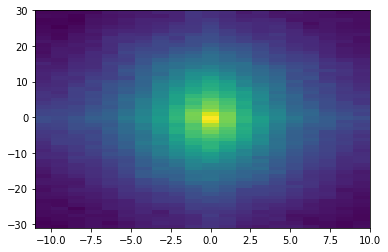

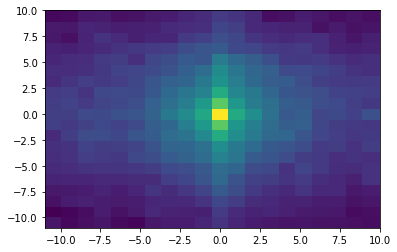

In [338]:
(Nz,Nx,Nt) = Ek3d.shape

kx = np.linspace(-Nx//2,Nx//2,Nx)
ky = np.linspace(-Ny//2,Ny//2,Ny)
kz = np.linspace(-Nz//2,Nz//2,Nz)

[Ky,Kx] = np.meshgrid(ky,kx)
plt.pcolormesh(Kx,Ky,np.log10(Ek3d[8,...]))

plt.figure()
[Kz,Kx] = np.meshgrid(kz,kx)
plt.pcolormesh(Kx,Kz,np.log10(Ek3d[...,11]))

(21, 21, 61)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice


[nan, nan, nan, nan, nan, nan, nan, 41.48845546964269, nan, nan, nan, 24.264254174114033, nan, 23.54160830136625, 10.57463608961724, 16.258920736278878, 13.149207091017956, 17.91622780568894, 13.221241548940895, 9.57408434238195, 8.822113550806394, 10.147331750893636, 7.403481185330721, 7.36120463012522, 6.923692571976328, 5.554128061644032, 5.976262714720357, 5.062171271803932, 5.132926520916116, 4.348094792109086, 4.342478589711693, 4.0661055770462395, 3.7553373300338366, 3.6071997008880126, 3.437709135990186, 3.3425284461189864, 3.2606034026378694, 3.192044013894191, 3.1488448398105757, 3.1032557775561025, 3.00814764646672, 2.9391049640698808, 2.8692419010495795, 2.789482858535044, 2.707071656829981, 2.644487014955455, 2.5965658166711703, 2.5373698725093674, 2.4221211684794195]


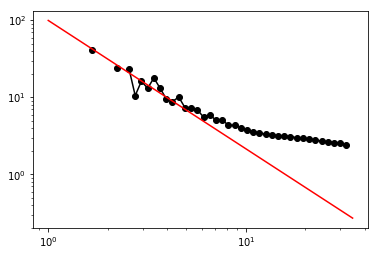

In [339]:
(Nt,Nz,Nx,Nt) = Ek.shape

kx = np.linspace(-Nx//2,Nx//2,Nx)
ky = np.linspace(-Ny//2,Ny//2,Ny)
kz = np.linspace(-Nz//2,Nz//2,Nz)

[Kx,Kz,Ky] = np.meshgrid(kx,kz,ky)
print(Kx.shape)

K = np.sqrt(Kx**2 + Ky**2 + Kz**2)

Klist = np.logspace(0,np.log10(np.max(K)),50)
E1d = []
for i,k0 in enumerate(Klist[:-1]):
    indices = np.logical_and(K>=Klist[i],K<Klist[i+1])
    #print(Ek[250,indices])
    dK = Klist[i+1]-Klist[i]
    Kmoy = (Klist[i+1]+Klist[i])/2
    
    val = np.nanmean(Ek[:,indices])
    E1d.append(val)

print(E1d)
plt.loglog(Klist[:-1],E1d,'ko-')
plt.loglog(Klist,100*Klist**(-5./3),'r-')

In [266]:
a = np.ones((299,40))
np.transpose(np.tile(a,(23,63,1,1)),(2,3,0,1)).shape

(299, 40, 23, 63)

1475


[1200, 1750, -0.2, 1.05]

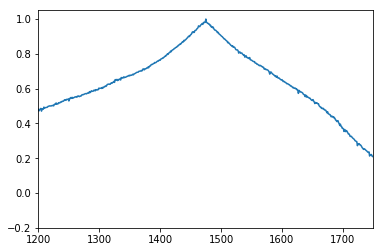

In [111]:
t = np.arange(0,2950,1)
n = len(t)
t0 = t[(n+1)//2]
print(t0)
ff2 = np.nanmean(fluc[t0,2:18,...,1]**2,axis=(0,1,2))
C = []
for tc in t:
#    print(tc)
    C.append(np.nanmean(fluc[tc,2:18,...,1]*fluc[t0,2:18,...,1],axis=(0,1,2))/ff2) 
plt.plot(t,C)
plt.axis([1200,1750,-0.2,1.05])

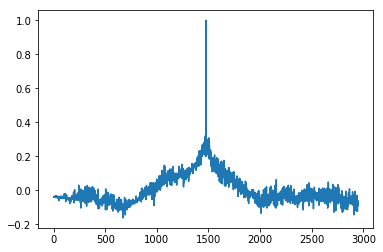

In [28]:
print(mean_flow.shape)
print(X[:,:,:].shape)

(40, 23, 63, 2)
(40, 23, 63)


NameError: name 'X' is not defined

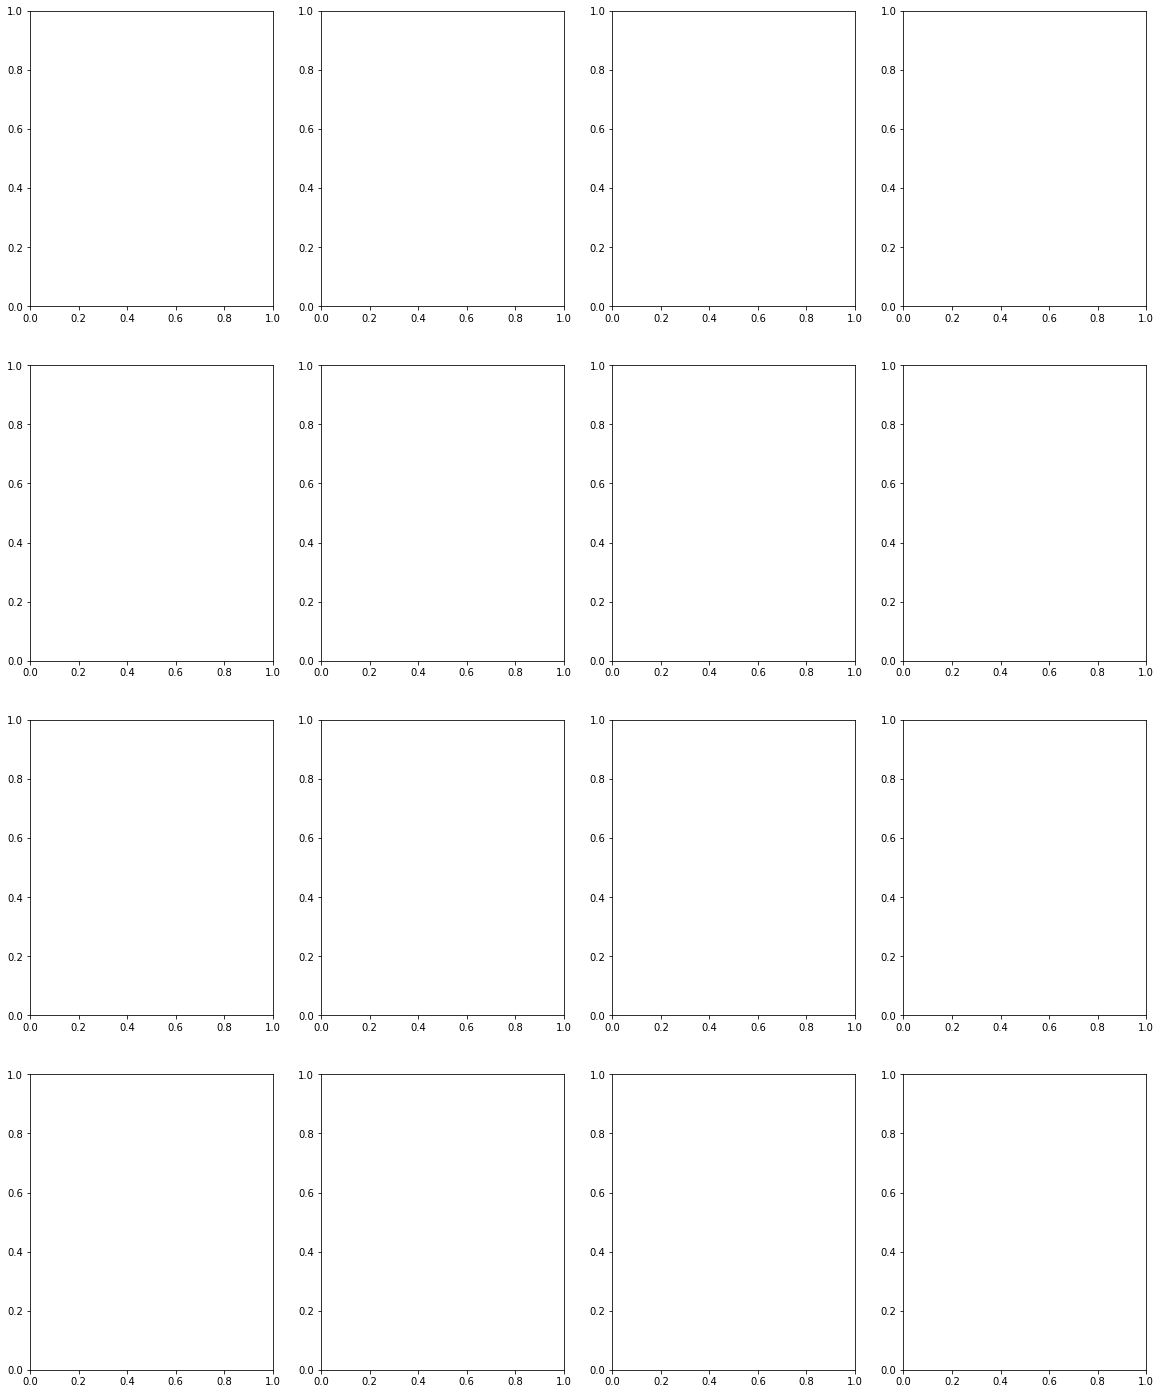

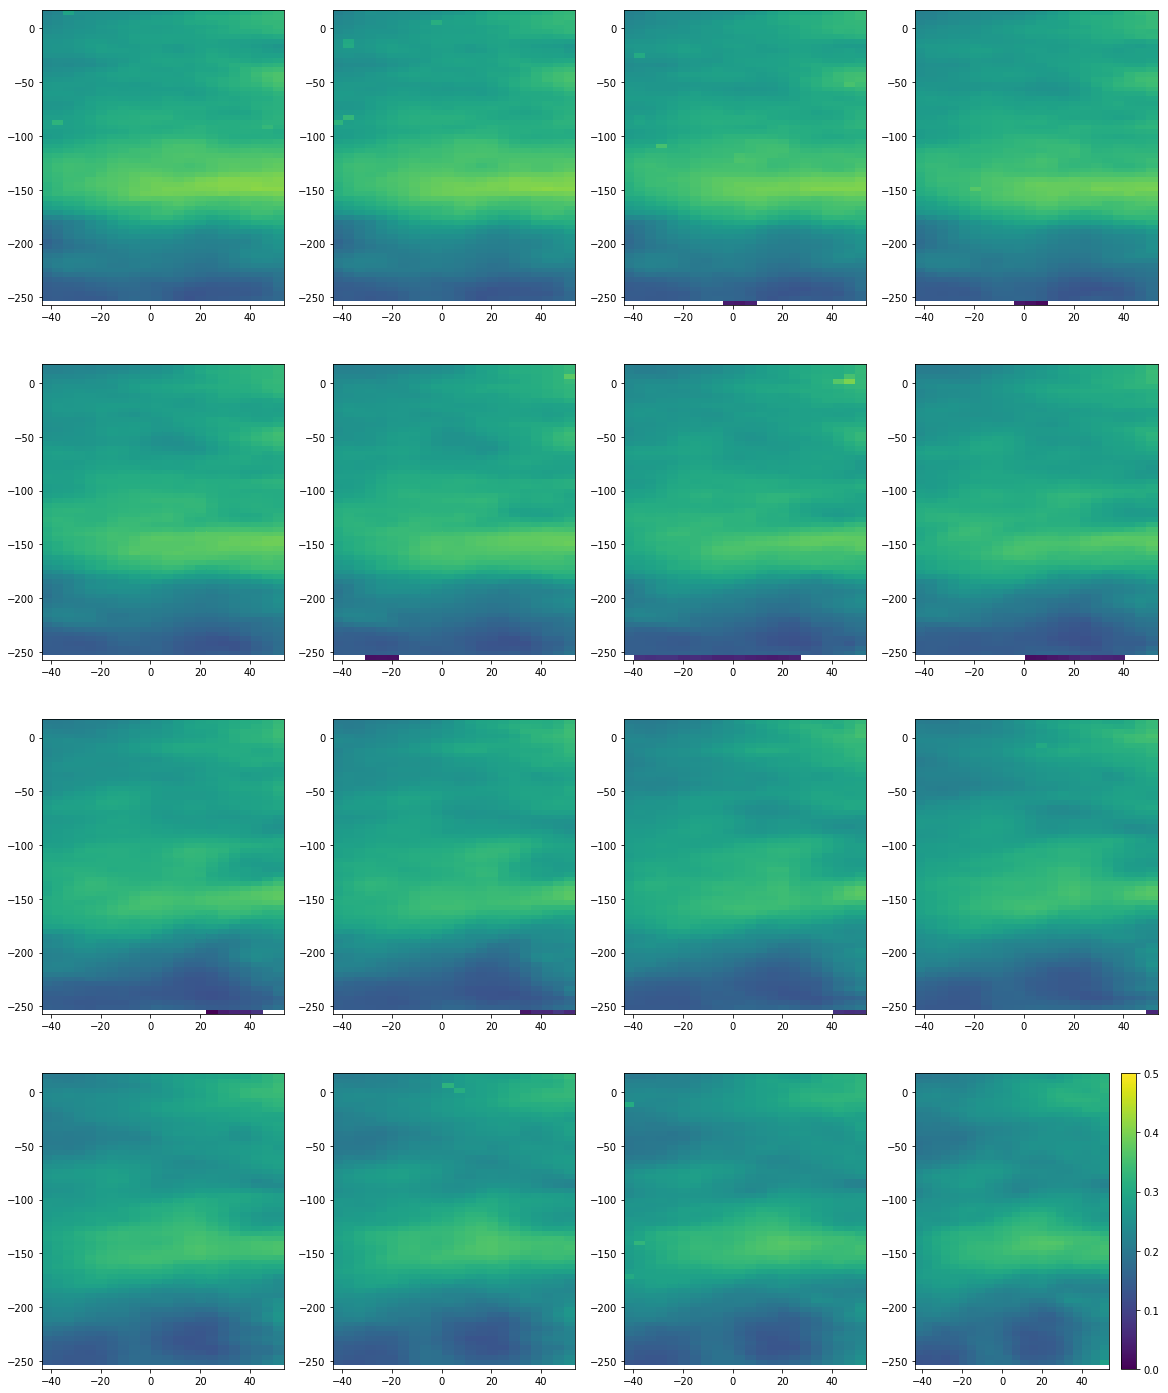

In [67]:
fig,axs=plt.subplots(4,4,figsize=(20,25))

for i in range(4):
    for j in range(4):
        plt.subplot(4,4,i*4+j+1)
        plt.pcolormesh(X[0,...],Y[0,...],u_rms[i*4+j,...],vmin=0,vmax=0.5)
plt.colorbar()

(23, 63)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


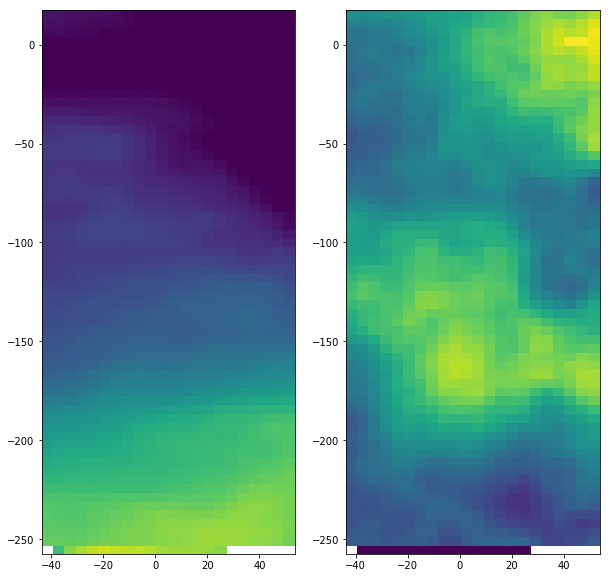

In [69]:
fig,axs=plt.subplots(1,2,figsize=(10,10))
print(mean_flow[10,...,0].shape)
axs[0].pcolormesh(X[0,...],Y[0,...],mean_flow[6,...,1],vmin=-0.3,vmax=0.3)
#plt.colorbar()

axs[1].pcolormesh(X[0,...],Y[0,...],np.nanmean(fluc[:,6,...,0]**2,axis=0),vmin=0,vmax=0.05)
#plt.colorbar()

In [338]:
[R,Theta] = Smath.cart2pol(X,Z)
Ur = 2*mean_flow[...,1]*np.cos(Theta)  #coefficient to be compensated by the circle fraction avalaible, so the coeff is r dependent
Utheta = -2*mean_flow[...,1]*np.sin(Theta) #average along Theta still required

fur = interp.RegularGridInterpolator((z,x,y),Ur,method='linear',bounds_error=False,fill_value=np.nan)
fut = interp.RegularGridInterpolator((z,x,y),Utheta,method='linear',bounds_error=False,fill_value=np.nan)
fuz = interp.RegularGridInterpolator((z,x,y),mean_flow[...,0],method='linear',bounds_error=False,fill_value=np.nan)

#futheta = interp.RegularGridInterpolator(Utheta, values, method='linear', bounds_error=True, fill_value=nan)[source]


In [248]:
print(Ur.shape)

(16, 31, 63)


In [242]:
helicity = fur((R[:,:,40]*np.cos(Theta[:,:,]),x[5],y[40]))

array([-0.073379  , -0.07342986, -0.06604033, -0.06482857, -0.06580828,
       -0.06344544, -0.05669815, -0.04911837, -0.03393364, -0.02424669,
       -0.01768416, -0.01310526, -0.00867227, -0.00059881,  0.00032977,
        0.00036066])

/usr/lib/python3/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/usr/lib/python3/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/usr/lib/python3/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice


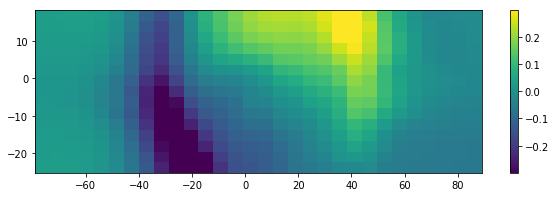

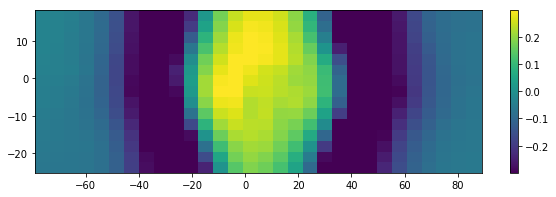

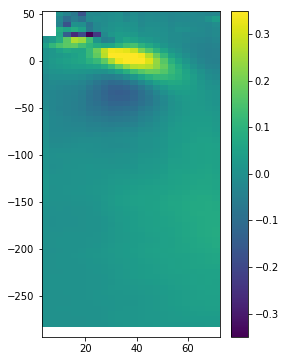

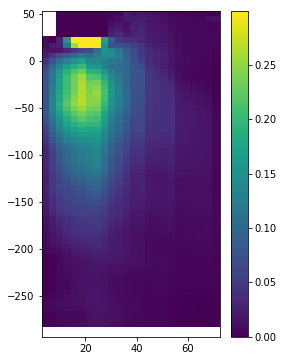

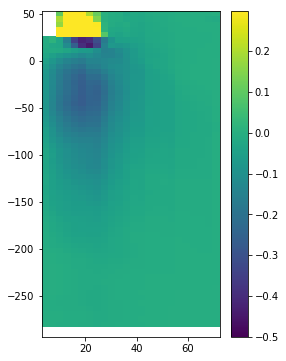

In [340]:
k =52

fig,axs=plt.subplots(1,1,figsize=(10,3))
plt.pcolormesh(X[...,0],Z[...,0],mean_flow[...,k,1],vmin=-0.3,vmax=0.3)
plt.colorbar()

fig,axs=plt.subplots(1,1,figsize=(10,3))
plt.pcolormesh(X[...,0],Z[...,0],mean_flow[...,k,0],vmin=-0.3,vmax=0.3)
plt.colorbar()



#fig,axs=plt.subplots(1,1,figsize=(10,3))
#plt.pcolormesh(X[...,0],Z[...,0],Ur[...,k],vmin=-0.3,vmax=0.3)
dtheta = 2*np.pi/50
theta = np.arange(np.pi/2,2*np.pi+np.pi/2,dtheta)
dr = dz
R0 = np.arange(dz,dz*(Nx-5),dz)
Nr = len(R0)

#plt.plot(np.min(R0)*np.cos(theta),np.min(R0)*np.sin(theta),'r')
#plt.plot(np.max(R0)*np.cos(theta),np.max(R0)*np.sin(theta),'r')

UR = np.zeros((Ny,Nr))
UT = np.zeros((Ny,Nr))
UZ = np.zeros((Ny,Nr))

for i in range(len(y)):
    for j,r0 in enumerate(R0):
        UR[i,j] = np.nanmean(fur((r0*np.cos(theta),r0*np.sin(theta),y[i])))
        UT[i,j] = np.nanmean(fut((r0*np.cos(theta),r0*np.sin(theta),y[i])))
        UZ[i,j] = np.nanmean(fut((r0*np.cos(theta),r0*np.sin(theta),y[i])))
    

fig,axs=plt.subplots(1,1,figsize=(4,6))
plt.pcolormesh(Rf,Yf,UR,vmin=-0.35,vmax=0.35)
plt.colorbar()


fig,axs=plt.subplots(1,1,figsize=(4,6))
plt.pcolormesh(Rf,Yf,-UT,vmin=0.,vmax=0.3)
plt.colorbar()

fig,axs=plt.subplots(1,1,figsize=(4,6))
plt.pcolormesh(Rf,Yf,UZ,vmin=-0.5,vmax=0.3)
plt.colorbar()

y
#fig,axs=plt.subplots(1,1,figsize=(10,3))
#plt.pcolormesh(X[...,0],Z[...,0],Utheta[...,k],vmin=-0.3,vmax=0.3)
#plt.colorbar()



#fig,axs=plt.subplots(1,1,figsize=(5,8))
#plt.pcolormesh(X[0,...],Y[0,...],mean_flow[6,...,1],vmin=-0.3,vmax=0.3)
#plt.colorbar()

In [192]:
#definition of mask
x0 = 175
y0 = 130
width = 120
height = 50

ValueError: cannot reshape array of size 31248 into shape (1,63)

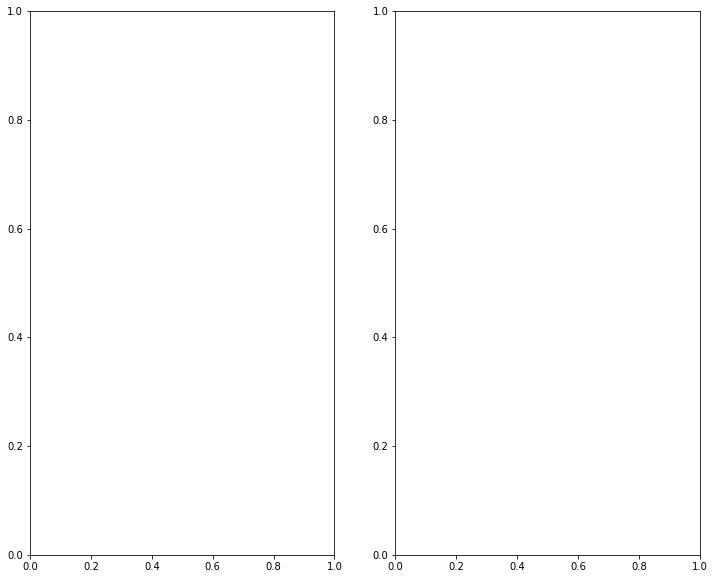

In [121]:
fig,axs=plt.subplots(1,2,figsize=(12,10)); axs=axs.flatten()
cax=[]
c=[]
j = 10
#for i in range(2):
#    divider = make_axes_locatable(axs[i])
#    cax.append(divider.append_axes('right', size='10%', pad=0.1))
    
for (i,data) in zip(range(2),[mean_speed[j,:,:],u_rms[j,:,:]]):
    #axs[i].clear()
    cb=axs[i].pcolormesh(X,Y,data,vmin=0,vmax=0.4)
#            cb=axs[i].pcolormesh(X,Y,ff[0,j,:,:,1],vmin=0,vmax=0.3)
#    fig.colorbar(cb)
#    c.append(fig.colorbar(cb, cax=cax[i], orientation='vertical'))

    axs[0].set_title(r'$y = '+str(int(z[j]))+' mm')
        #axs[1].set_title(r'$\bar u_{rms}$')

    axs[0].set_xlabel('$z$ (mm)')
    axs[i].set_xlabel('$x$ (mm)')
    #c[0].set_label(r'$\bar u$ (m/s)')
    #c[0].set_label(r'$\bar u_{rms}$ (m/s)')
    
    p=patches.Rectangle((x0,y0),width,height,facecolor='w',edgecolor='r')
    axs[i].add_patch(p)